### Part A

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

### Importing Data

In [14]:
movies_df = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/movie_info.csv')
ratings_df = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_all_development_set.csv')
ratings_df = ratings_df.rename(columns={'user_id': 'userId', 'item_id': 'movieId'})
movies_df = movies_df.rename(columns={'item_id': 'movieId'})
leaderboard_data = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_masked_leaderboard_set.csv') 

### Data Preprocessing

In [15]:
# Ensure required columns exist
assert 'userId' in ratings_df.columns and 'movieId' in ratings_df.columns and 'rating' in ratings_df.columns

# Encode user and movie IDs
user_encoder = LabelEncoder()
ratings_df['user_id_encoded'] = user_encoder.fit_transform(ratings_df['userId'])

movie_encoder = LabelEncoder()
ratings_df['movie_id_encoded'] = movie_encoder.fit_transform(ratings_df['movieId'])

# Copy the dataset and split into train and test sets
df = ratings_df.copy()
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Convert columns to NumPy arrays
train_user_ids = np.array(train['user_id_encoded'].values)
train_movie_ids = np.array(train['movie_id_encoded'].values)
train_ratings = np.array(train['rating'].values)

test_user_ids = np.array(test['user_id_encoded'].values)
test_movie_ids = np.array(test['movie_id_encoded'].values)
test_ratings = np.array(test['rating'].values)


# Define the number of unique users, movies, and embedding dimensions
num_users = df['user_id_encoded'].nunique()
num_movies = df['movie_id_encoded'].nunique()
embedding_dim = 50

### Getting embeddings

In [16]:
# User input and embedding
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_dim, name='user_embedding')(user_input)
user_embedding = Flatten()(user_embedding)

# Movie input and embedding
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies + 1, output_dim=embedding_dim, name='movie_embedding')(movie_input)
movie_embedding = Flatten()(movie_embedding)

### Defining the model and training

In [ ]:
# Define the model

# Dot product of embeddings and output layer
dot_product = Dot(axes=1)([user_embedding, movie_embedding])
output = Dense(1, activation='linear')(dot_product)

# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mae')

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user_ids, train_movie_ids], train_ratings,
    epochs=20,
    batch_size=64,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f"Test loss (MAE): {test_loss}")

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.0660 - val_loss: 2.6133
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2886 - val_loss: 1.4039
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9330 - val_loss: 0.7618
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4178 - val_loss: 0.7766
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3677 - val_loss: 0.7866
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3430 - val_loss: 0.7937
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.7601
Test loss (MAE): 0.7618473768234253


### Making the predictions

In [26]:
# Predict ratings for the test set
test_predictions = model.predict([test_user_ids, test_movie_ids])

# Create a DataFrame with predictions
test_results = pd.DataFrame({
    'original_user_id': test['userId'],
    'original_movie_id': test['movieId'],
    'actual_rating': test_ratings,
    'predicted_rating': test_predictions.flatten()
})
test_results['rating_difference'] = abs(test_results['actual_rating'] - test_results['predicted_rating'])

# Filter results for a specific user and sort by rating difference
filter_user_id = 772  # Replace with your desired user ID
filtered_results = test_results[test_results['original_user_id'] == filter_user_id]
filtered_results_sorted = filtered_results.sort_values(by='rating_difference')

print(f"Predictions for user {filter_user_id}, ordered by closest rating difference:")
print(filtered_results_sorted)

# Load leaderboard data
leaderboard_data = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_masked_leaderboard_set.csv')  # Replace with your leaderboard file path
assert 'user_id' in leaderboard_data.columns and 'item_id' in leaderboard_data.columns

# Handle unseen user and movie IDs using mapping
user_mapping = dict(zip(user_encoder.classes_, user_encoder.transform(user_encoder.classes_)))
movie_mapping = dict(zip(movie_encoder.classes_, movie_encoder.transform(movie_encoder.classes_)))

# Map user and movie IDs, assigning unseen IDs to placeholder index
leaderboard_data['user_id_encoded'] = leaderboard_data['user_id'].map(
    lambda x: user_mapping.get(x, num_users)
).astype(int)

leaderboard_data['item_id_encoded'] = leaderboard_data['item_id'].map(
    lambda x: movie_mapping.get(x, num_movies)
).astype(int)

# Predict leaderboard ratings
user_ids = leaderboard_data['user_id_encoded'].values
item_ids = leaderboard_data['item_id_encoded'].values
predictions = model.predict([user_ids, item_ids]).flatten()

# Save leaderboard predictions to a file
with open("predicted_ratings_leaderboard3.txt", "w") as f:
    for pred in predictions:
        f.write(f"{pred}\n")

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
Predictions for user 772, ordered by closest rating difference:
       original_user_id  original_movie_id  actual_rating  predicted_rating  \
10398               772                946              2          2.012197   
44904               772                 69              3          2.972420   
67026               772                893              2          2.291149   
21632               772                284              3          3.333319   
525                 772                175              4          3.547417   
13524               772                565              2          2.478595   
89249               772                391              2          2.483319   
19940               772               1019              5          4.372835   
38949               772                 95              2          2.643290   
74901               772                187              3          3.695869   
56211               772 

### Part B
1 figure (with caption) relevant to reporting how you trained the model or selected model complexity. This could be a trace plot or a hyperparameter selection plot.

### Finding best hyperparameters

In [ ]:
import itertools

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from sklearn.metrics import mean_absolute_error

def build_and_train_model(num_users, num_movies, embedding_dim, learning_rate, batch_size, epochs, patience, activation):
    # Define the model
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    user_embedding = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
    movie_embedding = Flatten()(movie_embedding)

    dot_product = Dot(axes=1)([user_embedding, movie_embedding])
    output = Dense(1, activation=activation)(dot_product)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    # Add early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    history = model.fit(
        [train_user_ids, train_movie_ids], train_ratings,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([test_user_ids, test_movie_ids], test_ratings),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    val_loss = model.evaluate([test_user_ids, test_movie_ids], test_ratings, verbose=0)
    return model, val_loss

# Define the hyperparameter grid
embedding_dims = [16, 32, 64, 128]
learning_rates = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]
activation = ['relu', 'linear']
epochs = [10, 50]
patience = 3

best_model = None
best_params = None
lowest_mae = float('inf')

results = {}
counter = 1
# 256 expected combinations
# Perform grid search
for emb_dim, lr, batch_size, act, epoch in itertools.product(embedding_dims, learning_rates, batch_sizes, activation, epochs):
    model, val_mae = build_and_train_model(num_users, num_movies, emb_dim, lr, batch_size, epoch, patience, act)

    print(counter)

    if val_mae < lowest_mae:
        lowest_mae = val_mae
        best_model = model
        best_params = (emb_dim, lr, batch_size)
        
    results[(emb_dim, lr, batch_size, act, epoch)] = val_mae

    counter += 1
    
print(f"\nBest Model Found: Embedding Dim={best_params[0]}, Learning Rate={best_params[1]}, Batch Size={best_params[2]}")
print(f"Lowest Validation MAE: {lowest_mae:.4f}")

In [55]:
print(results)
with open("results.txt", "w") as f:
    f.write(str(results))

{(16, 0.001, 32, 'relu', 10): 0.7434951663017273, (16, 0.001, 32, 'relu', 50): 0.7407206892967224, (16, 0.001, 32, 'linear', 10): 0.7396008372306824, (16, 0.001, 32, 'linear', 50): 0.7466884851455688, (16, 0.001, 64, 'relu', 10): 0.7389902472496033, (16, 0.001, 64, 'relu', 50): 0.736417293548584, (16, 0.001, 64, 'linear', 10): 0.7417230606079102, (16, 0.001, 64, 'linear', 50): 0.738938570022583, (16, 0.001, 128, 'relu', 10): 0.7487221956253052, (16, 0.001, 128, 'relu', 50): 0.7389059066772461, (16, 0.001, 128, 'linear', 10): 0.7350518107414246, (16, 0.001, 128, 'linear', 50): 0.7322984337806702, (16, 0.001, 256, 'relu', 10): 0.7354264259338379, (16, 0.001, 256, 'relu', 50): 0.7357543706893921, (16, 0.001, 256, 'linear', 10): 0.744534432888031, (16, 0.001, 256, 'linear', 50): 0.7364530563354492, (16, 0.005, 32, 'relu', 10): 0.7660120725631714, (16, 0.005, 32, 'relu', 50): 0.7701802253723145, (16, 0.005, 32, 'linear', 10): 0.7710860371589661, (16, 0.005, 32, 'linear', 50): 0.768797993659

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import GridSearchCV

# Function to create the model
def create_model(num_users, num_movies, embedding_dim, learning_rate, activation):
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    user_embedding = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
    movie_embedding = Flatten()(movie_embedding)

    dot_product = Dot(axes=1)([user_embedding, movie_embedding])
    output = Dense(1, activation=activation)(dot_product)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    return model

# Wrap the model with KerasRegressor
num_users = df['user_id_encoded'].nunique()
num_movies = df['movie_id_encoded'].nunique()

model = KerasRegressor(build_fn=create_model, num_users=num_users, num_movies=num_movies, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'embedding_dim': [16, 32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'batch_size': [32, 64, 128, 256],
    'activation': ['relu', 'linear'],
    'epochs': [10, 50]
}

# Create GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)

# Train and search
history = grid.fit(
    [train_user_ids, train_movie_ids], train_ratings,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    callbacks=[early_stopping]
)

# Print the best parameters and lowest MAE
print(f"Best Parameters: {grid.best_params_}")
print(f"Lowest Validation MAE: {-grid.best_score_:.4f}")

# Retrieve the best model
best_model = grid.best_estimator_.model

ImportError: cannot import name '_fit_context' from 'sklearn.base' (/Users/brandonmukadziwashe/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/base.py)

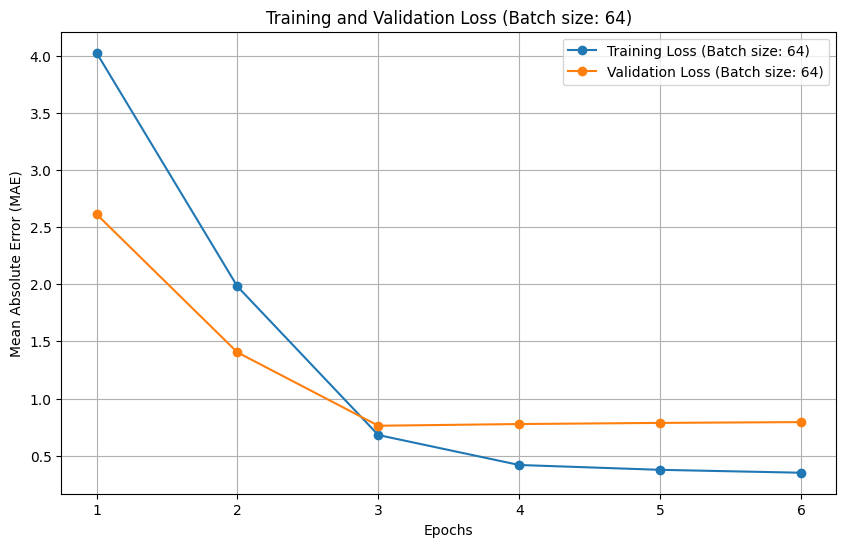

In [37]:
import matplotlib.pyplot as plt

# Extract training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
# Define batch size
batch_size = 64  # Replace with the actual batch size used during training

# Plotting the trace
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label=f'Training Loss (Batch size: {batch_size})', marker='o')
plt.plot(epochs, val_loss, label=f'Validation Loss (Batch size: {batch_size})', marker='o')
plt.title(f'Training and Validation Loss (Batch size: {batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Fully connected layers
x = Dense(256, activation='relu')(concatenated)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
